# Integrative analysis of pathway deregulation in obesity
### Extracting the obesity signature
Here we show how to extract a transcriptomic signature of obesity after having merged 4 independent datasets in [this notebook](link). We obtain a signature composed of only 38 genes, as explained in 

F. Font-Clos, S. Zapperi, C.A.M. La Porta  
Integrative analysis of pathway deregulation in obesity  
*npj Systems Biology and Applications (accepted)*, 2017  
[insert link](link). 



In [1]:
%reset -f
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

import copy

/Users/fran/miniconda2/envs/obesity-score/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/fran/miniconda2/envs/obesity-score/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import sklearn

### Load gene-expression data for batches 1-4
We have already removed batch-effects [in this notebook](link) (you might need to run it before proceeding if you're executing this one locally). So we just load the pickled dataframes, which correspond to the gene expression data of batches 1 to 4.

In [9]:
geno = pd.read_pickle("../output/batches1-4_merged/batch1234_geno.p")
pheno = pd.read_pickle("../output/batches1-4_merged/batch1234_pheno.p")

### Compute first principal component
We compute the first principal component of the gene-expression dataframe. We also load Gene Symbol annotations.

In [11]:
v = (PCA().fit(geno)).components_[0]
v_df = pd.DataFrame(columns=["coef","abs_coef"],index = geno.columns)
v_df["coef"] = v
v_df["abs_coef"] = np.abs(v)
v_df.sort_values(by="abs_coef",ascending=False,inplace=True)
v_df.drop("abs_coef",axis=1,inplace=True)

In [12]:
hugo_df = pd.read_table("../data/gene_dictionaries/HUGO_official_list_20160613.txt")
entrez_to_genesymb = dict(hugo_df[["Entrez Gene ID","Approved Symbol"]].astype(unicode).applymap(lambda x:x.split(".")[0]).values)

In [13]:
v_df["GeneSymb"] = v_df.index.map(lambda x:entrez_to_genesymb[x] if x in entrez_to_genesymb.keys() else "???")
v_df.index.name = "Entrez"
v_df.set_index("GeneSymb",append=True,inplace=True)

So now we have a dataframe with genes in the index and the coefficients of the first principal component of batch1-4 as the only column. We have actually sorted the genes by absolute value of coefficient:

In [14]:
v_df.head()

,,coef
Entrez,GeneSymb,
1278,COL1A2,0.131414
80763,SPX,-0.126199
761,CA3,-0.088910
219348,PLAC9,0.074152
25975,EGFL6,0.073139


### Set a statistical significance threshold
The first principal component of the gene-expression data can be thought of as a direction in gene-space. To set a threshold for statistical significance, we compare the coefficients we have with those of a random direction in this same space. 

A random direction in a space of dimension $N$ has standard Gaussian coefficients, see [Muller,1959](http://dl.acm.org/citation.cfm?id=377946). If the norm of our signature vector equals one, then the coefficients of a random direction of the same norm must have variance $1/N$, and thus the distribution of the coefficients of a random direction are Gaussians with standard deviation $\sigma = 1/\sqrt{N}$.

We then decide to set a threshold of $5\sigma$, that is, **we keep only those coefficients that are boeyond 5 sigma's** of what we would expect at random.

In [15]:
N = geno.shape[1]
sigma = 1/np.sqrt(N)

There are only 38 genes above our $5\sigma$ threshold. We discard the rest:

In [16]:
idx = np.abs(v_df.coef)>5*sigma
print "genes beyond threshold:",idx.sum()

genes beyond threshold: 38


In [17]:
signature = v_df.loc[idx]

### Plot signature
Here we reproduce Figure 1d in the manuscript

In [18]:
v_df["abscoef"] = v_df["coef"].apply(np.abs)

In [19]:
# do an ensemble of fake signatures
tmp = np.array([sorted(np.abs(np.random.normal(size=v_df.shape[0])/np.sqrt(v_df.shape[0]))) for x in range(100)])
m=tmp.mean(axis=0)
s=tmp.std(axis=0)

In [20]:
labelsize=16  # fontsize of x,y labels
title_size=18  # fontsize of the title       
ticks_size=14  # fontsize of numbers in x,y ticks
latex_size=18  # fontsize of latex-rendered pval, corr_coef annotations

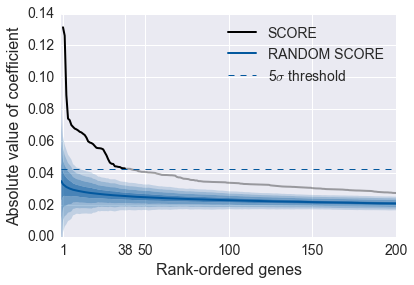

In [21]:
plt.figure(figsize=(6,4))

# internal parameters
t = range(1,N+1)
Ng = 2000
mycolor = "#03589E"
M=20
K2=5

# MAIN PLOT
plt.plot((t[:38]),v_df["abscoef"].values[:38],color="black",linestyle="-",linewidth="2",label="SCORE")
plt.plot((t[38:]),v_df["abscoef"].values[38:],color="black",alpha=0.35,linestyle="-",linewidth="2")

# SHADOWS
for j in [-1,1]:
    for K in range(0,M,5):
        plt.fill_between(range(Ng),(m+j*(K)*s)[::-1][:Ng],(m+j*(K+5)*s)[::-1][:Ng],
                         color=mycolor,linewidth=0,alpha=0.7*(M-K)/M)

# RANDOM SIGNATURE
plt.plot((m)[::-1][:Ng],color=mycolor,linestyle="-",linewidth=2,label="RANDOM SCORE")

# 5-SIGMA THRESHOLD
plt.axhline(K2/np.sqrt(v_df.shape[0]),linewidth=1,color=mycolor,linestyle="--",label="%d$\sigma$ threshold" %K2,)

# AXIS
plt.ylim([0,.14])
plt.xlim([0,200])
plt.xlabel("Rank-ordered genes",size=labelsize)
plt.ylabel("Absolute value of coefficient",size=labelsize)
plt.xticks([1,38,50,100,150,200],size=ticks_size)
plt.yticks(size=ticks_size)
plt.legend(fontsize=14)

plt.savefig("../output/figures/Figure1d.pdf")
plt.show()

### Save signature
We save the signature in pickled and CSV form, as well as a list of all the genes in the final gene-expression matrix. These are known as the **background** genes, and must be used to correctly identify overrepresented gene sets.

In [22]:
signature.to_csv("../output/signature/signature.csv")
signature.to_pickle("../output/signature/signature.p")

In [23]:
np.savetxt("../output/batches1-4_merged/background_genes.txt",v_df.index.get_level_values(0).values,fmt="%s")